In [1]:
import zipfile, os, shutil,re
from os.path import isfile, isdir
from matplotlib import pyplot as plt
# import time
import random
import numpy as np
# import h5py
import pandas as pd
import cv2
# from tqdm import tqdm
import keras
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense,Input,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import load_model

from keras import backend as K
import tensorflow as tf
# The below tf.set_random_seed() will make random number generation
tf.set_random_seed(2018)
sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto())
K.set_session(sess)

# dynamically allocate GPU memory
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

# train image number 25,000 , test image number 12,500 , set batch_size = 25
batch_size = 50
epochs = 40

# extract train image to folder 'train' and 'test'
train_path = 'train'
test_path = 'test'
# extract train
if not isdir(train_path):
    zipFile = zipfile.ZipFile('train.zip')
    zipFile.extractall()
    zipFile.close()
    
# move cat's image to folder 'train/cat/', dog's image to folder 'train/dog'
if not isdir('train/cat'):
    os.mkdir('train/cat')
if not isdir('train/dog'):
    os.mkdir('train/dog')
    
for filename in os.listdir('train'):
    match_obj1 = re.search(r'cat.[0-9]*.jpg',filename)
    if match_obj1:
        shutil.move('train/'+filename, 'train/cat/')
    
    match_obj2 = re.search(r'dog.[0-9]*.jpg',filename)
    if match_obj2:
        shutil.move('train/'+filename, 'train/dog/'+filename)
        
# extract test image to folder 'test'
if not isdir('test'):
    zipFile = zipfile.ZipFile('test.zip')
    zipFile.extractall()
    zipFile.close()
    os.mkdir('test/test')
    for file in os.listdir('test'):
        if not os.path.isdir(file):
            shutil.move('test/'+file,'test/test/')

C:\Users\thomas_gui\AppData\Local\conda\conda\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_catfile = ['train/cat/cat.%d.jpg' % i for i in range(12500)]
X_dogfile = ['train/dog/dog.%d.jpg' % i for i in range(12500)]
# print(X_catfile[:10])
# set the validation split = 0.2
# then split train_set into X_train,X_val, y_train, y_val
splitpoint = int(12500 * 0.8)
# print(splitpoint)
X_catfile_train,X_catfile_val = X_catfile[:splitpoint],X_catfile[splitpoint:]
X_dogfile_train,X_dogfile_val = X_dogfile[:splitpoint],X_dogfile[splitpoint:]

X_train = np.array(X_catfile_train + X_dogfile_train)
y_train = np.array([0 for i in range(splitpoint)] + [1 for i in range(splitpoint)])
X_val = np.array(X_catfile_val + X_dogfile_val)
y_val = np.array([0 for i in range(splitpoint,12500)] + [1 for i in range(splitpoint,12500)])

train_idx = np.arange(20000)
val_idx = np.arange(5000)
random.seed(2018)
random.shuffle(train_idx)
# print(train_idx)
random.seed(2018)
random.shuffle(val_idx)
X_train,y_train = X_train[train_idx],y_train[train_idx]
X_val,y_val = X_val[val_idx],y_val[val_idx]
#print(X_train[:10])
#print(y_train[:10])
#print(y_train.sum())    #一半是猫，一半是狗，total sum = 10,000


In [3]:
def random_crop(img, ratio=1.0):
    #随机剪裁, Ratio是裁剪后与裁剪前的面积比
    if random.random() < 1:
        h,w = img.shape[:2]
        #长宽比随机扰动变量 hw_delta
        hw_delta = np.random.uniform(-0.05,0.05)
        hw_mult = 1 + hw_delta
        
        w_crop = int(round(w*np.sqrt(ratio*hw_mult)))
        
        if w_crop > w:
            w_crop = w
        
        h_crop = int(round(h*np.sqrt(ratio/hw_mult)))
        if h_crop > h:
            h_crop = h
        
        x0 = np.random.randint(0,w-w_crop+1)
        y0 = np.random.randint(0,h-h_crop+1)
        
        img = img[y0:y0+h_crop,x0:x0+w_crop]
        
    return img
    
def random_rotate(img, angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        # angle = np.random.uniform(-angle,angle)
        # angle cycle is 360
        angle %= 360
        # 用openCV 内置函数计算仿射矩阵
        M_rotate = cv2.getRotationMatrix2D((w/2,h/2),angle,1)
        # 得到旋转后的图片
        img = cv2.warpAffine(img, M_rotate, (w, h))
    return img

def random_shear(img,angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        #产生随机剪切角度值
        # angle = np.random.uniform(-angle,angle)
        # x轴剪切变换，角度值=angle
        theta = angle * np.pi / 180
        M_shear = np.array([[1,np.tan(theta), 0],[0,1,0]],dtype = np.float32)
        img = cv2.warpAffine(img, M_shear, (w, h))
    return img

def random_h_flip(img, horizontal_flip=False):
    if horizontal_flip == True:
        if random.random() < 1:
            img = cv2.flip(img, 1)
    return img
            
def ramdom_v_flip(img, vertical_flip=False):
    if vertical_flip == True:
        if random.random() < 1:
            img = cv2.flip(img,0)
    return img    

def train_generator(X=None, y=None, batch_size=32,ratio=None,rotate=None,shear=None,
                  horizontal_flip=False,vertical_flip=False): 
    params = {}
    if ratio is not None:
        params['ratio'] = ratio
    if rotate is not None:
        params['rotate'] = rotate
    if shear is not None:
        params['shear'] = shear
    if horizontal_flip:
        params['horizontal_flip'] = horizontal_flip
    if vertical_flip:
        params['vertical_flip'] = vertical_flip
        
    if params:
        func = []
        for param in params.keys():
            func.append(param)
    func = random.choice(func)
    # print(func,params[func])
    
    function_map = { 'ratio':random_crop,
                     'rotate':random_rotate,
                     'shear':random_shear,
                     'horizontal_flip':random_h_flip,
                     'vertical_flip':ramdom_v_flip
                    }
    
    datalen = len(X)
    counter = datalen//batch_size
    
    X_299 = np.zeros((datalen,299,299,3),dtype=np.uint8)
    X_224 = np.zeros((datalen,224,224,3),dtype=np.uint8)
    
    # print("\nwaiting for generating train samples......\n")
    for i in range(datalen):
        X_img = cv2.imread(X[i])
        X_img = function_map[func](X_img,params[func])
        X_299[i] = cv2.resize(X_img,(299,299))
        X_224[i] = cv2.resize(X_img,(224,224))  
    # print("generated %d train samples\n"%datalen)
    
    random.seed(2018)
    index = np.arange(counter)
    random.shuffle(index)
    
    while (True):
        for i in range(counter):
            yield [(X_299[index[i] * batch_size:(index[i] + 1) * batch_size]-127.5)/127.5,
                  (X_224[index[i] * batch_size:(index[i] + 1) * batch_size]-127.5)/127.5], \
                    y[index[i] * batch_size:(index[i] + 1) * batch_size]
            
def val_generator(X=None, y=None, batch_size=32):
    
    datalen = len(X)
    counter = datalen//batch_size
    
    X_299 = np.zeros((datalen,299,299,3),dtype=np.uint8)
    X_224 = np.zeros((datalen,224,224,3),dtype=np.uint8)
    
    # print("\nwaiting for generating validation samples......\n")
    for i in range(datalen):
        X_img = cv2.imread(X[i])
        X_299[i] = cv2.resize(X_img,(299,299))
        X_224[i] = cv2.resize(X_img,(224,224))    
    # print("generated %d validation samples\n"%datalen)
    
    while (True):
        for i in range(counter):
            yield [(X_299[i * batch_size:(i + 1) * batch_size]-127.5)/127.5,
                  (X_224[i * batch_size:(i + 1) * batch_size]-127.5)/127.5], y[i * batch_size:(i + 1) * batch_size]
            

In [4]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

inception_V3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (299, 299,3),pooling='avg')
for layer in inception_V3.layers:
    layer.trainable = False

xception = Xception(include_top= False, weights='imagenet',input_shape=(299,299,3),pooling='avg')
for layer in xception.layers:
    layer.trainable = False
    
resnet50 = ResNet50(include_top= False, weights='imagenet',input_shape=(224,224,3),pooling='avg')
for layer in resnet50.layers:
    layer.trainable = False

input1 = Input((299,299,3))
input2 = Input((224,224,3))

x1 = inception_V3(input1)
x2 = xception(input1)
x3 = resnet50(input2)

x = keras.layers.concatenate([x1,x2,x3])
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
x = Dense(1,activation = 'sigmoid')(x)
tune_model = Model(inputs=[input1,input2],outputs=x)
optimizer_adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-10)
tune_model.compile(loss = 'binary_crossentropy', optimizer =optimizer_adadelta, metrics =['accuracy'])
#plot_model(tune_model, to_file='model_add_BN.png',show_shapes = True) 
#SVG(model_to_dot(tune_model).create(prog='dot', format='svg'))
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 2048)         21802784    input_4[0][0]                    
__________________________________________________________________________________________________
xception (Model)                (None, 2048)         20861480    input_4[0][0]                    
__________________________________________________________________________________________________
resnet50 (

In [5]:
# in case, computer crash in a specified epoch, save checkpointer of model
# restore a previous model to continue traing from the specified epoch.
# tune_model = load_model('./model/tune_model.h5')

checkpointer = ModelCheckpoint('./model/tune_model.h5', monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='auto', period=1)
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

logger = CSVLogger('./model/log.csv', separator=',', append=True)

# if restore previous model, may train from specified epoch by parameters "initial_epoch= "
model_history = tune_model.fit_generator(train_generator(X_train, y_train, batch_size,0.9,20,20,True,True),
                                         steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                         validation_data = val_generator(X_val, y_val, batch_size),
                                         validation_steps=len(y_val)//batch_size,
                                         callbacks = [earlystop,checkpointer,logger],
                                         verbose=1)

Epoch 1/40
400/400 [==============================] - 1169s 3s/step - loss: 0.1668 - acc: 0.9371 - val_loss: 0.0616 - val_acc: 0.9842
Epoch 2/40
400/400 [==============================] - 772s 2s/step - loss: 0.0823 - acc: 0.9678 - val_loss: 0.0505 - val_acc: 0.9856
Epoch 3/40
400/400 [==============================] - 769s 2s/step - loss: 0.0675 - acc: 0.9738 - val_loss: 0.0485 - val_acc: 0.9862
Epoch 4/40
400/400 [==============================] - 761s 2s/step - loss: 0.0601 - acc: 0.9760 - val_loss: 0.0480 - val_acc: 0.9858
Epoch 5/40
400/400 [==============================] - 763s 2s/step - loss: 0.0554 - acc: 0.9780 - val_loss: 0.0479 - val_acc: 0.9856
Epoch 6/40
400/400 [==============================] - 764s 2s/step - loss: 0.0518 - acc: 0.9793 - val_loss: 0.0480 - val_acc: 0.9856
Epoch 7/40
400/400 [==============================] - 763s 2s/step - loss: 0.0489 - acc: 0.9809 - val_loss: 0.0481 - val_acc: 0.9858
Epoch 8/40
400/400 [==============================] - 773s 2s/step -

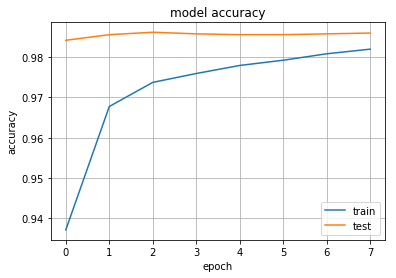

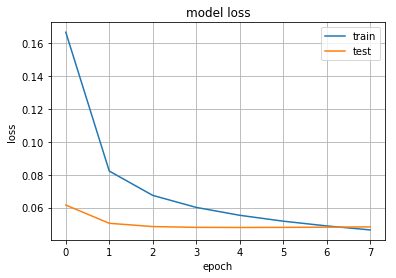

In [6]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])  
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(model_history.history['loss'])  
plt.plot(model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [7]:
import pandas as pd

test_datagen = ImageDataGenerator()
test_299 = test_datagen.flow_from_directory(
        'test/',
        target_size=(299, 299),
        batch_size=25,
        shuffle = False,
        class_mode=None)
test_224 = test_datagen.flow_from_directory(
        'test/',
        target_size=(224, 224),
        batch_size=25,
        shuffle = False,
        class_mode=None)

def test_generator():
    while (True):
        X_299 = test_299.next()
        X_224 = test_224.next()
        yield [(X_299-127.5)/127.5,(X_224-127.5)/127.5]

predictions = tune_model.predict_generator(test_generator(),steps = 500, verbose =1)
predictions = predictions.clip(min=0.005,max=0.995)

output = pd.read_csv('sample_submission.csv')
for i, filename in enumerate(test_299.filenames):
    # print(filename)
    index = int(filename[filename.rfind('\\') + 1 : filename.rfind('.')])
    output.loc[index-1 ,'label'] = predictions[i]
    
output.to_csv('predictions_Final.csv',index=None)

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
500/500 [==============================] - 424s 848ms/step
